# COVID-19 on reddit's front page
[J. Nathan Matias](https://natematias.com) and Eric Pennington

March 14, 2020




## Load System Environment

In [1]:
%matplotlib inline
import inspect, os, sys, copy, pytz, re, glob, csv, uuid, time, requests, math, jsonlines, datetime
os.environ['AIRBRAKE_API_KEY'] = "ca826dbd1a4594241c239bba825edd9f" ## EDIT BEFORER USING
os.environ['AIRBRAKE_PROJECT_ID'] = "-1" ## EDIT BEFORE USING

import simplejson as json
import pandas as pd
from dateutil import parser
import datetime
import matplotlib.pyplot as plt   # Matplotlib for plotting
import matplotlib.dates as md
import numpy as np
import seaborn as sns
from collections import Counter, defaultdict
utc=pytz.UTC

ENV = "production"
os.environ['CS_ENV'] = 'production'
BASE_DIR = "/usr/local/civilservant/platform"
sys.path.append(BASE_DIR)

with open(os.path.join(BASE_DIR, "config") + "/{env}.json".format(env=ENV), "r") as config:
  DBCONFIG = json.loads(config.read())

### LOAD SQLALCHEMY
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy import text, and_, or_
import sqlalchemy.orm.session
import utils.common


db_engine = create_engine("mysql://{user}:{password}@{host}/{database}".format(
    host = DBCONFIG['host'],
    user = DBCONFIG['user'],
    password = DBCONFIG['password'],
    database = DBCONFIG['database']))
DBSession = sessionmaker(bind=db_engine)
db_session = DBSession()


### LOAD PRAW
#import reddit.connection
#conn = reddit.connection.Connect(base_dir=BASE_DIR, env="jupyter")

from app.models import *
from app.models import Base, SubredditPage, FrontPage, Subreddit, Post, ModAction
from utils.common import PageType

### FILTER OUT DEPRECATION WARNINGS ASSOCIATED WITH DECORATORS
# https://github.com/ipython/ipython/issues/9242
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='.*use @default decorator instead.*')

Logging to /usr/local/civilservant/platform/logs/CivilServant_production.log


## Settings

In [61]:
#subreddit = sys.argv[2]
opening_date = "12/01/2019"
#opening_date = "03/01/2020"
closing_date = "03/15/2020"

bg_cache_file = "front_page_posts_{0}_{1}.jsonl".format(
        opening_date.replace("/","-"), closing_date.replace("/","-"))

#print(bg_cache_file)
#print("front_page_posts_12-01-2019_03-14-2020.csv")

## Utility Methods

#### Querying CivilServant

In [62]:

## Query and construct rank vectors from CivilServant
def construct_rank_vectors(is_subpage):
    rank_vectors = {}   # rank_vectors[subid][pt][pid][page.created_at] = i
    max_rank_vectors = {} # [pid][subid][pt] = i

    for pt in [PageType.TOP, PageType.HOT]:
        print(pt)
        if is_subpage:
            pages = db_session.query(SubredditPage).filter(and_(SubredditPage.page_type == pt.value,SubredditPage.created_at >= parser.parse(opening_date), SubredditPage.created_at <= parser.parse(closing_date)))
        else:
            pages = db_session.query(FrontPage).filter(and_(FrontPage.page_type == pt.value,
                                                            FrontPage.created_at >= parser.parse(opening_date), 
                                                            FrontPage.created_at <= parser.parse(closing_date)))
        for page in pages:
            subid = "FRONT PAGE"
            if is_subpage:
                subid = page.subreddit_id
            posts = json.loads(page.page_data)
            for i,post in enumerate(posts):
                pid = post['id']

                #CURVE WORK
                if subid not in rank_vectors:
                    rank_vectors[subid] = {}
                if pt not in rank_vectors[subid]:
                    rank_vectors[subid][pt] = {}
                if pid not in rank_vectors[subid][pt]:                
                    rank_vectors[subid][pt][pid] = {}
                rank_vectors[subid][pt][pid][page.created_at] = i

                #MAX RANK WORK
                if pid not in max_rank_vectors:
                    max_rank_vectors[pid] = {}
                if subid not in max_rank_vectors[pid]:
                    max_rank_vectors[pid][subid] = {}
                if (pt not in max_rank_vectors[pid][subid]) or (i < max_rank_vectors[pid][subid][pt]):
                    # max rank = smallest number placement
                    max_rank_vectors[pid][subid][pt] = i

    return rank_vectors, max_rank_vectors

#### Querying PushShift

In [63]:
def getPSPosts(ids):
    url = "https://api.pushshift.io/reddit/search/submission/?ids={0}".format(
    ",".join(ids)
    )
    r = requests.get(url)
    data = json.loads(r.text)
    return data['data']

## Load List of Everything Appearing on Reddit's Front Page During COVID-19

Date range: December 2019 - present

(test: one week of reddit)

In [64]:
#srank_vectors, smax_rank_vectors = construct_rank_vectors(True)

rank_vector_start = datetime.datetime.utcnow()

frank_vectors, fmax_rank_vectors = construct_rank_vectors(False)

rank_vector_end = datetime.datetime.utcnow()

print("Completed rank vector collection from {0} posts in in {1} seconds".format(
    len(fmax_rank_vectors),
    (rank_vector_end - rank_vector_start).total_seconds()
))

PageType.TOP
PageType.HOT
Completed rank vector collection from 65672 posts in in 35.990119 seconds


In [65]:
# print("Completed rank vector collection from {0} posts in in {1} seconds".format(
#     len(fmax_rank_vectors),
#     (rank_vector_end - rank_vector_start).total_seconds()
# ))

## Query all posts appearing on the front page

In [66]:
# dir(frank_vectors['FRONT PAGE'])
# list(frank_vectors['FRONT PAGE'][PageType.TOP].keys())[0]
# frank_vectors['FRONT PAGE'][PageType.TOP]['6zndrp']

In [67]:
fp_post_id_set = set(frank_vectors['FRONT PAGE'][PageType.TOP].keys())
print("{0} on top".format(len(fp_post_id_set)))
fp_post_id_set.update(set(frank_vectors['FRONT PAGE'][PageType.HOT].keys()))
print("{0} total".format(len(fp_post_id_set)))
fp_post_ids = list(fp_post_id_set)


21542 on top
65672 total


In [68]:
all_posts = {}
page_size = 1000
courtesy_delay = 0.25
est_query_time = 0.3

bg_begin = datetime.datetime.utcnow()

try:
    print("LOAD FILE")
    with jsonlines.open(bg_cache_file) as r:
        for post in r:
            all_posts[post['id']] = post
        print("Finished loading {0}".format(bg_cache_file))
    ## if you can't find the posts, then 
except FileNotFoundError:
    ## dict of posts, with a key associated with the post ID
    print("{0} not found. Querying from BG dataset.")
    print("Loading {0} posts with {1} queries. Estimate time: {2} minutes".format(
        len(fp_post_ids),
        math.ceil(len(fp_post_ids)/page_size),
        math.ceil(math.ceil((len(fp_post_ids)/page_size)*courtesy_delay + (len(fp_post_ids)/page_size)*est_query_time)/60)

    ))

    head = 0
    tail = page_size
    while(head <= len(fp_post_ids)):
        sys.stdout.write(".")
        sys.stdout.flush()
        ids = fp_post_ids[head:tail]
        if(len(ids)>0):
            posts = getPSPosts(ids)
            for post in posts:
#                post['post_week'] = datetime.datetime.fromtimestamp(post['created_utc']).strftime("%Y%U")
                all_posts[post['id']] = post
        time.sleep(courtesy_delay)
        head += page_size
        tail += page_size
    print("\nLoading complete")
    with jsonlines.open(bg_cache_file, "w") as w:
        w.write_all(list(all_posts.values()))
        print("Finished writing to {0}".format(bg_cache_file))
        
bg_end = datetime.datetime.utcnow()

print("Completed in {0} seconds".format((bg_end - bg_begin).total_seconds()))

LOAD FILE
{0} not found. Querying from BG dataset.
Loading 65672 posts with 66 queries. Estimate time: 1 minutes
..................................................................
Loading complete
Finished writing to front_page_posts_12-01-2019_03-15-2020.jsonl
Completed in 144.228294 seconds


# Analysis of Posts Appearing on the Front Page

### Detect plausibly covid-19 related posts

In [81]:
covid_tokens = ['coronavirus', 
                'covid',
                'corona',
                'wuhan',
                'pandemic', 
                'outbreak',
                'epidemic',
                'cdc',
                'social distance', 'self-isolate', 'self isolate',
                'quarantine', 
                'sanitizer', 'toilet paper', "TP", 'wipes', 
                'world health',
                'community spread']

In [82]:
## iterate through posts and tag ones related to covid-19
num_matches = 0
total_reviewed = 0

match_terms = defaultdict(list)

for post_id, post in all_posts.items():
    ltitle = post['title'].lower()
    post['covid_19'] = False
    for token in covid_tokens:
        if ltitle.find(token) > -1:
            post['covid_19'] = True
            match_terms[token].append(ltitle)
    if(post['covid_19']):
        num_matches += 1
    total_reviewed += 1
            
print("""
Out of {} posts appearing on reddit front pages (TOP and HOT) 
between {} and {}, {} are covid-19 related ({:.02f}%)""".format(
    total_reviewed,
    opening_date,
    closing_date,
    num_matches,
    num_matches/len(all_posts)*100
))


Out of 65666 posts appearing on reddit front pages (TOP and HOT) 
between 12/01/2019 and 03/15/2020, 729 are covid-19 related (1.11%)


### Most common domains

In [169]:
Counter([x['domain'] for x in list(all_posts.values()) if x['covid_19']]).most_common(15)

[('i.redd.it', 198),
 ('twitter.com', 33),
 ('i.imgur.com', 28),
 ('independent.co.uk', 22),
 ('businessinsider.com', 20),
 ('self.Showerthoughts', 16),
 ('cnbc.com', 13),
 ('v.redd.it', 11),
 ('scmp.com', 8),
 ('theguardian.com', 8),
 ('commondreams.org', 8),
 ('washingtonpost.com', 8),
 ('self.AskReddit', 7),
 ('imgur.com', 7),
 ('gfycat.com', 7)]

### Maximum Rank Analysis
(in this calculation, posts with a value of 0 appeared at the top of the list, and posts with a value of 100 appeared at the bottom of the list)

In [121]:
rank_keys = {
    PageType.HOT: "hot",
    PageType.TOP: "top"
}

for post in all_posts.values():
    post['max_hot'] = post['max_top'] = 0
    post['front_top_seconds'] = post['front_hot_seconds'] = np.nan
    
    ## max rank column
    if post['id'] in fmax_rank_vectors.keys():
        max_rank = fmax_rank_vectors[post['id']]
        for key,value in max_rank['FRONT PAGE'].items():
            post['week'] = datetime.datetime.fromtimestamp(post['created_utc']).strftime("%Y%U")
            post["max_{0}".format(rank_keys[key])] = value
    ## time on front page (top)
    
    for key, value in frank_vectors['FRONT PAGE'].items():
        if post['id'] in value.keys():
            ranks = sorted(list(value[post['id']].items()), 
                           key=lambda x: x[0])
            earliest_rank = ranks[0]
            last_rank = ranks[-1]
            post['front_{0}_seconds'.format(rank_keys[key])] = (last_rank[0] - earliest_rank[0]).total_seconds()
        

#### Average Maximum Rank

In [85]:
print("Average maximum rank (HOT) of NON-coronavirus content: {:0.2f}".format(
    np.mean([x['max_hot'] for x in all_posts.values() if x['covid_19']!=True])
))
print("Average maximum rank (HOT) of coronavirus content: {:0.2f}".format(
    np.mean([x['max_hot'] for x in all_posts.values() if x['covid_19']])
))

Average maximum rank (HOT) of NON-coronavirus content: 38.94
Average maximum rank (HOT) of coronavirus content: 30.10


In [86]:
print("Average maximum rank (TOP) of NON-coronavirus content: {:0.2f}".format(
    np.mean([x['max_top'] for x in all_posts.values() if x['covid_19']!=True])
))
print("Average maximum rank (TOP) of coronavirus content: {:0.2f}".format(
    np.mean([x['max_top'] for x in all_posts.values() if x['covid_19']])
))

Average maximum rank (TOP) of NON-coronavirus content: 15.79
Average maximum rank (TOP) of coronavirus content: 15.20


#### Average Front Seconds

In [89]:
print("Average seconds on (HOT) of NON-coronavirus content: {:0.2f}".format(
    np.nanmean([x['front_hot_seconds'] for x in all_posts.values() if x['covid_19']!=True])
))
print("Average seconds on (HOT) of coronavirus content: {:0.2f}".format(
    np.nanmean([x['front_hot_seconds'] for x in all_posts.values() if x['covid_19']])
))

Average seconds on (HOT) of NON-coronavirus content: 14234.02
Average seconds on (HOT) of coronavirus content: 14856.37


In [90]:
print("Average seconds on (TOP) of NON-coronavirus content: {:0.2f}".format(
    np.nanmean([x['front_top_seconds'] for x in all_posts.values() if x['covid_19']!=True])
))
print("Average seconds on (TOP) of coronavirus content: {:0.2f}".format(
    np.nanmean([x['front_top_seconds'] for x in all_posts.values() if x['covid_19']])
))

Average seconds on (TOP) of NON-coronavirus content: 42416.16
Average seconds on (TOP) of coronavirus content: 46081.46


In [91]:
top_posts_covid_19 = [x for x in all_posts.values() if x['covid_19']]
top_covid_posts_df = pd.DataFrame(top_posts_covid_19)

In [92]:
top_posts_filename = "covid19_top_posts_front_page_{0}_{1}.csv".format(
        opening_date.replace("/","-"), closing_date.replace("/","-"))
top_posts_filename

'covid19_top_posts_front_page_12-01-2019_03-15-2020.csv'

In [131]:
top_covid_posts_df.to_csv(top_posts_filename, columns=[
    "id", "title", "url", "week", "created_utc", "full_link", "is_self", "selftext", "is_video", "media",
    "subreddit", "subreddit_id", "subreddit_subscribers", 
    "max_top", "front_top_seconds", 
    "max_hot", "front_hot_seconds"
])

### Front Page Posts Per Day about COVID-19 on Reddit

In [108]:
all_counts = Counter([datetime.datetime.fromtimestamp(x['created_utc']).strftime("%Y%m%d") 
                      for x in top_posts_covid_19])

elapsed_days = (parser.parse(closing_date) - parser.parse(opening_date)).days
day_counts = {}
for i in range(0,elapsed_days):
    daykey = (parser.parse(opening_date) + datetime.timedelta(days=i)).strftime("%Y%m%d") 
    if daykey in all_counts:
        day_counts[daykey] = all_counts[daykey]
    else:
        day_counts[daykey] = 0
        
day_count_list = sorted([x for x in day_counts.items()], key=lambda x: x[0])

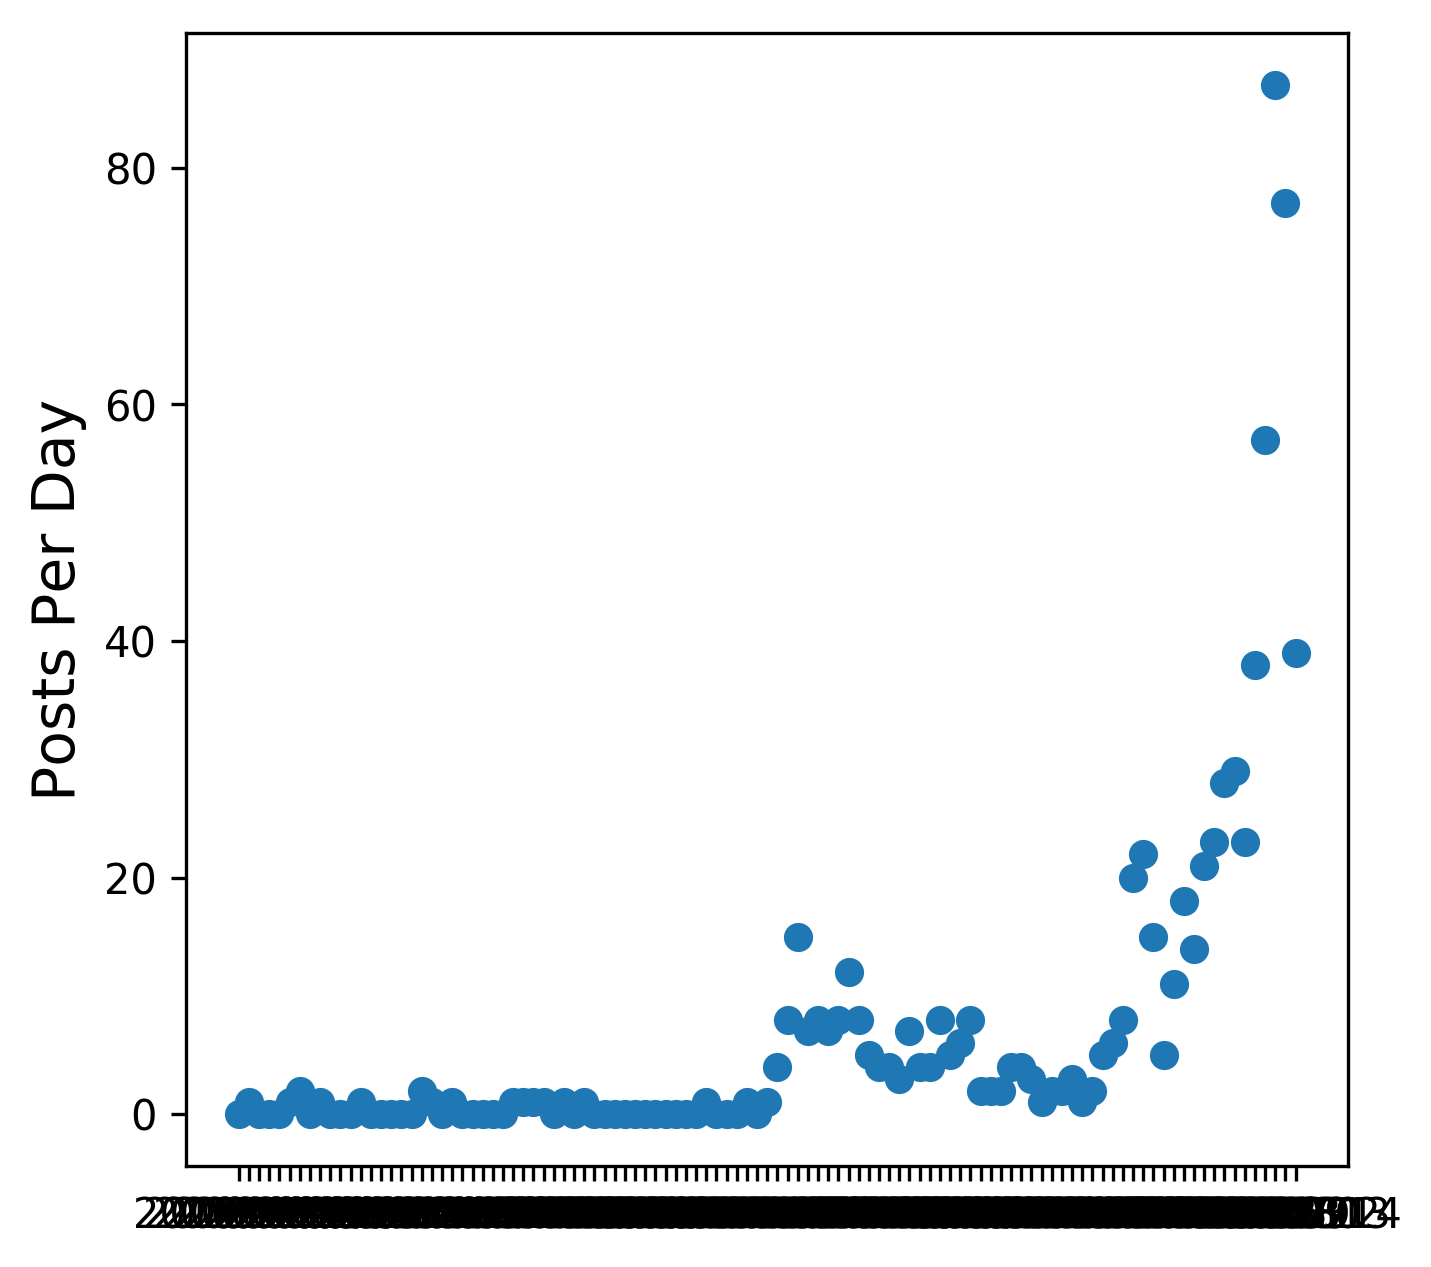

In [166]:
plt.figure(figsize=(5, 5), dpi= 300, facecolor='w', edgecolor='k')
#plt.title("(DRAFT) Covid-19 posts per day promoted by reddit algorithms (TOP and HOT)(Dec 1 2019 - March 14 2020)", fontsize=20)
plt.scatter([x[0] for x in day_count_list], [x[1] for x in day_count_list])
#plt.xticks([x[0] for x in day_count_list], [x[0] for x in day_count_list], rotation=45, fontsize=6)
plt.ylabel("Posts Per Day", fontsize=14)
plt.show()

#### Top 10 Subreddits

In [167]:
Counter([x['subreddit'] for x in list(all_posts.values()) if x['covid_19']]).most_common(10)

[('worldnews', 103),
 ('politics', 77),
 ('Coronavirus', 53),
 ('nottheonion', 19),
 ('memes', 17),
 ('funny', 16),
 ('Showerthoughts', 16),
 ('pics', 16),
 ('atheism', 13),
 ('science', 13)]

In [159]:
len([x['subreddit'] for x in list(all_posts.values()) if x['covid_19']])

729